In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn as sns

# Laser

Load the data:

In [2]:
matlabFile = scipy.io.loadmat('laser.mat')
X = matlabFile["X"]
y = -matlabFile["Y"].flatten() # "-1" means intact, "+1" means defect

# First Analysis

First, let's have a look at the data and visualize all intensity curves:

In [3]:
def plotIndividualIntensitySeries(X, y, indices = []):
    if indices == []:
        indices = np.arange(X.shape[0])
    plt.subplot(1, 2, 1)
    for i in indices:
        if y[i] == -1:
            plt.plot(np.arange(60), X[i,:], alpha=0.35)
    plt.ylabel("intensity")
    plt.xlabel("t in s")
    plt.title("Intact lasers")
    plt.subplot(1, 2, 2)
    for i in indices:
        if y[i] == 1:
            plt.plot(np.arange(60), X[i,:], alpha=0.35)
    plt.ylabel("intensity")
    plt.xlabel("t in s")
    plt.title("Faulty lasers")
    plt.tight_layout()
    plt.show()

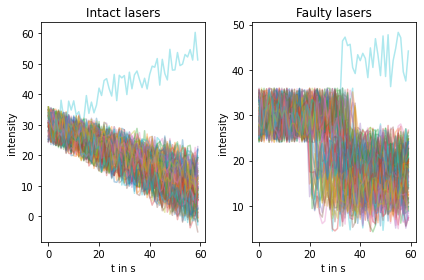

In [4]:
plotIndividualIntensitySeries(X, y)

There are two outliers (instances 35 and 162) that can be determined with np.where(X[:,59] > 30). Maybe with these two outliers, the intensity was measured to increase, instead of decrease. We could correct for that, but since we are not sure about that, we instead drop these two instances later, since they make up only one percent of the training data.

Let's quick have a look at how well intact and defect lasers are separated. As a distance measure, we use the Dynamic Time Warp distance. We build the distance matrix $D_{ij} = d(x_i, x_j)$ and plot it.

In [5]:
def DTWDistance(seq1, seq2):
    m, n = len(seq1), len(seq2)
    if m == 0 and n == 0: # both sequences have length 0
        return 1
    elif m == 0 or n == 0: # only one of them has length 0
        return np.inf
    DTWMatrix = np.empty((m+1, n+1))
    for i in range(m+1):
        for j in range(n+1):
            DTWMatrix[i, j] = np.inf
    DTWMatrix[0, 0] = 0
    for i in range(1, m+1):
        for j in range(1, n+1):
            distance = np.abs(seq1[i-1] - seq2[j-1])
            DTWMatrix[i, j] = distance + min(DTWMatrix[i-1, j], DTWMatrix[i, j-1], DTWMatrix[i-1, j-1])
    return DTWMatrix[m, n]

def DTWDistanceMatrix(X):
    distanceMatrix = np.empty((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        # print("Computing distance matrix. row", i + 1, "of", X.shape[0])
        for j in range(X.shape[0]):
            if i == j:
                distanceMatrix[i, j] = 0
            if i < j:
                distanceMatrix[i, j] = DTWDistance(X[i, :], X[j, :])
            else:
                distanceMatrix[i, j] = distanceMatrix[j, i]
    return distanceMatrix

def plotDTWDistancesMatrix(D):
    ax = sns.heatmap(D)
    plt.title("Distances between instances")
    plt.show()

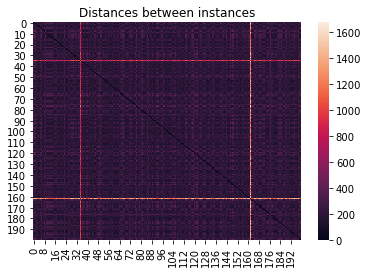

In [6]:
D = DTWDistanceMatrix(X)
plotDTWDistancesMatrix(D)

Here we clearly see the two outliers, since they have great distances to the other instances. Now might be a good time to get rid of them.

In [7]:
outliers = [35, 162]
X = np.delete(X, outliers, axis=0)
y = np.delete(y, outliers, axis=0)
D = np.delete(D, outliers, axis=0)
D = np.delete(D, outliers, axis=1)

Let's look at the D-Matrix again, but this time with more focus on the ordinary instances:

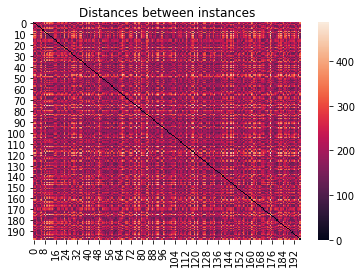

In [8]:
plotDTWDistancesMatrix(D)

If we take a look at the data, we see that they are not sorted in any way, so we omit shuffeling them for any randomization purposes. Next, we will cluster the lasers into intact and defect ones, and compute the silhouette coefficient of this clustering. This will lie in [-1, 1], the higher the better.

In [9]:
def silhouetteCoefficient(D, C):
    s = np.zeros(D.shape[0])
    for i in range(D.shape[0]):
        a = D[i,C == C[i]].mean()
        b = D[i,C != C[i]].mean()
        s[i] = (b-a)/max(a, b)
    return s.mean()

def analyzeSilhouetteCoefficient(D, C, tries=1000):
    silhouette = silhouetteCoefficient(D, C)
    print("Silhouette of best cluster:", silhouette)
    silhouettes = np.zeros(tries)
    for i in range(tries):
        clusterCandidate = np.random.randint(2, size=len(C))
        silhouettes[i] = silhouetteCoefficient(D, clusterCandidate)
    print("Mean of random clusters:", silhouettes.mean())
    print("Min  of random clusters:", silhouettes.min())
    print("Max  of random clusters:", silhouettes.max())

In [10]:
analyzeSilhouetteCoefficient(D, y)

Silhouette of best cluster: 0.25237978991846266
Mean of random clusters: 0.009941946330410043
Min  of random clusters: 0.0016524482712904505
Max  of random clusters: 0.03406751386883923


We observe a silhouette index of about 0.25, which is significantly higher than that of a random clustering, as shown. To visualize the cluster quality, we sort the D-matrix by laser quality labels.

In [11]:
def plotSortedDTWDistanceMatrix(originalD, y):
    D = originalD.copy() # in order to not change the original D matrix
    D = D[np.concatenate((np.where(y==-1), np.where(y==1)), axis=None),:]
    D = D[:,np.concatenate((np.where(y==-1), np.where(y==1)), axis=None)]
    plotDTWDistancesMatrix(D)

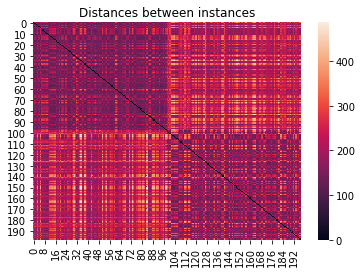

In [12]:
plotSortedDTWDistanceMatrix(D, y)

As we see, the intact lasers lie closer to another than to the defect ones, and vice versa, whereas the defect lasers are not clustered as good. This gives some hope.

# First Model: DTW Kernel
As a distance measure for instances we use the DTW distance, for which we already have the distance matrix $D$. As a kernel function we define $k(x_i, x_j) = e^{-c*d(x_i, x_j)}$ where $c=1/max(D)$. Since we only have access to the kernel function and not the feature mapping, we use a dual view s.t. our decision function is defined as $f_\alpha(x)=\sum_i \alpha_i k(x_i, x)$, where $x_i$ are the training instances and $\alpha$ is determined by kernel ridge regression: $\alpha = (K + \lambda * I)^{-1}y$ where $K$ is the kernel matrix of training instances, $\lambda$ is a regularization parameter, $I$ is the Identity matrix and $y$ are the class labels of the training instances.

In [13]:
class DTWClassifier():
    def __init__(self, X_train, y_train, D, lbda=1, X_extended=None, D_extended=None):
        self.c = 1 / np.max(D)
        self.K = np.exp(-self.c * D)
        self.X = X_train
        self.alpha = np.linalg.solve(self.K + lbda * np.eye(len(y_train)), np.eye(len(y_train))) @ y_train
        # For evaluation purposes, we provide the class with all available training data,
        # as well as with the orginal distances, so they don't have to be recomputed
        # everytime we compare two known instances against another.
        self.X_extended = X_extended
        self.D_extended = D_extended
    def score(self, X):
        if X.ndim == 1:
            output = 0
            for i in range(len(self.alpha)):
                distance = DTWDistance(X, self.X[i, :])
                output[i] += self.alpha[i] * np.exp(-distance * self.c)
            return output
        elif X.ndim == 2:
            output = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                instanceIndex = -1
                if self.X_extended is not None:
                    for k in range(self.X_extended.shape[0]):
                        equality = True
                        for l in range(60):
                            if self.X_extended[k, l] != X[i, l]:
                                equality = False
                                break
                        if equality == True:
                            instanceIndex = k
                if instanceIndex >= 0:
                    for j in range(len(self.alpha)):
                        distance = self.D_extended[instanceIndex, j]
                        output[i] += self.alpha[j] * np.exp(-distance * self.c)
                else:
                    for j in range(len(self.alpha)):
                        distance = DTWDistance(X[i, :], self.X[j, :])
                        output[i] += self.alpha[j] * np.exp(-self.c * distance)
            return output
    def predict(self, X):
        scores = self.score(X)
        if X.ndim == 1:
            if scores <= 0:
                scores = -1
            else:
                scores = 1
        elif X.ndim == 2:
            scores[scores <= 0] = -1
            scores[scores > 0] = 1
        return scores
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return sum(y_pred == y) / len(y)

## Nested cross validation for Kernel Ridge Classification
In order to figure out the optimal hyperparameter $\lambda$, we perform a nested cross validation. We choose $k=9$ and look for values for $\lambda$ in [0.0001, 10]

In [43]:
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = int(num_samples / k)
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i * fold_size:(i + 1) * fold_size] = True
        masks.append(mask)
    return masks

def nestedCrossValidation(X, y, D, lbda_values=np.logspace(-4, 1, 241), k=9):
    print("Nested cross validation in progress: optimizing lambda for DTW Classification.")
    masks = create_kfold_mask(X.shape[0], k)
    risk = np.zeros(k)
    risk_per_lbda = dict.fromkeys(lbda_values)
    for lbda in lbda_values:
        risk_per_lbda[lbda] = 0
    for i in range(k):
        # print("i =", i+1, "of", k)
        min_risk_lbda = np.inf
        best_lbda_i = 0
        for lbda in lbda_values:
            # print(" lbda =", lbda)
            risks_i_lbda = np.zeros(k)
            for j in range(k):
                if j != i:
                    train_indices = masks[i] == False
                    train_indices[masks[j]] = False
                    # Train model
                    clf_ij = DTWClassifier(X[train_indices],
                                           y[train_indices],
                                           D[np.ix_(train_indices, train_indices)],
                                           lbda,
                                           X,
                                           D[:, train_indices])
                    # Determine risk on S_j
                    y_pred_ij = clf_ij.predict(X[masks[j]])
                    risks_i_lbda[j] = sum(y_pred_ij != y[masks[j]]) / len(y_pred_ij)
                    risk_per_lbda[lbda] += risks_i_lbda[j]
            # Average R_S_j to determine risk...
            avg_risk_i_lbda = sum(risks_i_lbda) / (k-1)
            # Choose lambda that minimizes risk
            if avg_risk_i_lbda <= min_risk_lbda:
                best_lbda_i = lbda
                min_risk_lbda = avg_risk_i_lbda
        # train model on S \ S_i
        tuning_indices = masks[i] == False
        clf_i =  DTWClassifier(X[tuning_indices],
                               y[tuning_indices],
                               D[np.ix_(tuning_indices, tuning_indices)],
                               best_lbda_i,
                               X,
                               D[:, tuning_indices])
        # Determine risk for i on S_i
        y_pred_i = clf_i.predict(X[masks[i]])
        risk[i] = sum(y_pred_i != y[masks[i]]) / len(y_pred_i)
    # average risks
    avg_risk = risk.mean()
    # determine best lambda
    lowest_lambda_risk = np.inf
    best_lbda = 0
    for lbda in lbda_values:
        if risk_per_lbda[lbda] <= lowest_lambda_risk:
            best_lbda = lbda
            lowest_lambda_risk = risk_per_lbda[lbda]
    # train model on all data
    trained_tuned_and_tested = DTWClassifier(X, y, D, best_lbda, X, D)
    # Plot the relevant data
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    lbdaRisksVector = []
    for lbda in lbda_values:
        lbdaRisksVector.append(risk_per_lbda[lbda] / (k * (k - 1)))
    # print("lbdaRisksVector:", lbdaRisksVector)
    ax.plot(lbda_values, lbdaRisksVector)
    plt.xlabel("lambda")
    plt.ylabel("averaged risk over all S_i, S_j")
    ax.set_xscale("log")
    plt.title("Nested Cross Validation: average risk per lambda")
    plt.show()
    return trained_tuned_and_tested, best_lbda, avg_risk

Nested cross validation in progress: optimizing lambda for DTW Classification.


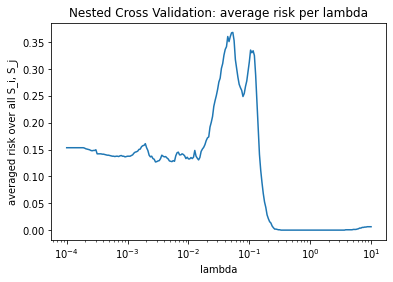

Accuracy of Kernel Ridge Classifier with DTW Kernel: 1.0
Best lambda: 3.651741272548377 , avg. risk overall: 0.0


In [44]:
dtwClassifierBestLbda, bestLbdaDTWKernel, avgRiskDTWKernel = nestedCrossValidation(X, y, D, k=9)
print("Accuracy of Kernel Ridge Classifier with DTW Kernel:", dtwClassifierBestLbda.accuracy(X, y))
print("Best lambda:", bestLbdaDTWKernel, ", avg. risk overall:", avgRiskDTWKernel)

## Kernel Perceptron
Since we achieve an accuracy of 100%, we know that our data is linearly separable in the higher feature space. Thus, we can construct a Kernel Perceptron:

In [16]:
class KernelPerceptron():
    def __init__(self, X, y, D):
        self.alpha = np.zeros(X.shape[1])
        self.X = X
        self.D = D
        self.c = 1/np.max(D)
        while True:
            alphaChanged = False
            for i in range(X.shape[0]):
                if y[i]*self.f(X[i]) <= 0:
                    self.alpha[i] += y[i]
                    alphaChanged = True
            if not alphaChanged:
                break
    def k(self, index_of_x1, x2):
        index2 = -1
        for i in range(self.X.shape[0]):
            match2 = True
            for l in range(len(self.X[i])):
                if self.X[i, l] != x2[l]:
                    match2 = False
                    break
            if match2: index2 = i
        if index2 >= 0:
            distance = self.D[index_of_x1, index2]
        else:
            distance = DTWDistance(self.X[index_of_x1], x2)
        return np.exp(-self.c * distance)
    def f(self, x):
        score = 0
        for i in range(len(self.alpha)):
            score += self.alpha[i] * self.k(i, x)
        if score <= 0:
            return -1
        else:
            return 1
    def predict(self, X):
        output = np.zeros(X.shape[0])
        for i in range(len(output)):
            output[i] = self.f(X[i])
        return output
    def accuracy(self, X_true, y_true):
        y_pred = self.predict(X_true)
        return sum(y_pred == y_true) / len(y_true)

In [17]:
kernelPerceptron = KernelPerceptron(X, y, D)
print("Accuracy of Kernel Perceptron:", kernelPerceptron.accuracy(X, y))

Accuracy of Kernel Perceptron: 1.0


As expected, our Perceptron also achieves 100% accuracy. However, let's look at the weight vector of the Perceptron:

In [18]:
print("Weight vector of Perceptron:", kernelPerceptron.alpha)
print("Non-zero-entries at", np.where(kernelPerceptron.alpha != 0))

Weight vector of Perceptron: [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Non-zero-entries at (array([ 0,  1, 13, 18, 40, 42]),)


That vector is very sparse, and it seems counterintuitive to only take into account the intensities at 0s, 1s, 13s, 18s, 40s and 42s to detect if a laser is defect. In conclusion, we prefer the Ridge Classification Model.

# Linear models

## Ridge Classification

To present a naive approach, we can construct a ridge classifier without regularization, using about 3/4 of the available training data. (Were we to use all training data, the model would classify all training data correctly, but that would be overfitting).

In [19]:
def L2Regularizer(theta):
    return sum(theta*theta)

def ridgeClassification(X, y, lbda=1):
    theta = np.linalg.solve(np.transpose(X) @ X + lbda*np.eye(X.shape[1]), np.eye(X.shape[1])) @ np.transpose(X) @ y
    return theta

class RidgeClassifier():
    def __init__(self, X, y, lbda=1):
        X_train = X.copy()
        self.means = np.zeros(X.shape[1])
        self.stds = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            self.means[j] = X[:,j].mean()
            self.stds[j] = X[:, j].std()
            X_train[:,j] = (X_train[:,j] - self.means[j]) / self.stds[j]
        self.thetaNormalized = ridgeClassification(np.hstack((np.ones((X_train.shape[0], 1)), X_train)), y, lbda)
        self.theta = ridgeClassification(np.hstack((np.ones((X.shape[0], 1)), X)), y, lbda)
    def score(self, X):
        X_query = X.copy()
        for j in range(X_query.shape[1]):
            X_query[:,j] = (X_query[:,j] - self.means[j]) / self.stds[j]
        return X_query @ self.thetaNormalized[1:len(self.thetaNormalized)] + self.thetaNormalized[0]
    def predict(self, X):
        scores = self.score(X)
        scores[scores <= 0] = -1
        scores[scores > 0] = 1
        return scores
    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        return sum(y_pred == y_true) / len(y_true)
    def getThetaNormalized(self):
        return self.thetaNormalized

In [20]:
naiveLinearClassifier = RidgeClassifier(X[0:150], y[0:150], 0)
print("Accuracy of naive ridge classifier:", naiveLinearClassifier.accuracy(X[150:198], y[150:198]))

Accuracy of naive ridge classifier: 0.9791666666666666


Although we can already correctly predict a large proportion of test instances, we still might encounter a case of overfitting. Let's look at the weight vector of the model:

In [ ]:
print("L2 norm:", L2Regularizer(naiveLinearClassifier.thetaNormalized))

It has an L2 norm of 0.49 (in the normalized form). As we will see, we can easily lower this norm, misclassifying only two instances of our given set, which seems like an acceptable tradeoff. Again, we will use nested cross validation to obtain the best regularization parameter $\lambda$:

In [29]:
def nestedCrossValidationRidgeClassification(X, y, lbda_values=np.logspace(0, 3, 91), k=18):
    print("Nested cross validation in progress: optimizing lambda for Ridge Classification.")
    masks = create_kfold_mask(X.shape[0], k)
    risk = np.zeros(k)
    risk_per_lbda = dict.fromkeys(lbda_values)
    for lbda in lbda_values:
        risk_per_lbda[lbda] = 0
    for i in range(k):
        # print("i =", i+1, "of", k)
        min_risk_lbda = np.inf
        best_lbda_i = 0
        for lbda in lbda_values:
            # print(" lbda =", lbda)
            risks_i_lbda = np.zeros(k)
            for j in range(k):
                if j != i:
                    train_indices = masks[i] == False
                    train_indices[masks[j]] = False
                    # Train model
                    clf_ij = RidgeClassifier(X[train_indices], y[train_indices], lbda)
                    # Determine risk on S_j
                    y_pred_ij = clf_ij.predict(X[masks[j]])
                    risks_i_lbda[j] = sum(y_pred_ij != y[masks[j]]) / len(y_pred_ij)
                    risk_per_lbda[lbda] += risks_i_lbda[j]
            # Average R_S_j to determine risk...
            avg_risk_i_lbda = sum(risks_i_lbda) / (k-1)
            # Choose lambda that minimizes risk
            if avg_risk_i_lbda <= min_risk_lbda:
                best_lbda_i = lbda
                min_risk_lbda = avg_risk_i_lbda
        # train model on S \ S_i
        tuning_indices = masks[i] == False
        clf_i =  RidgeClassifier(X[tuning_indices], y[tuning_indices], best_lbda_i)
        # Determine risk for i on S_i
        y_pred_i = clf_i.predict(X[masks[i]])
        risk[i] = sum(y_pred_i != y[masks[i]]) / len(y_pred_i)
    # average risks
    avg_risk = risk.mean()
    # determine best lambda
    lowest_lambda_risk = np.inf
    best_lbda = 0
    for lbda in lbda_values:
        if risk_per_lbda[lbda] <= lowest_lambda_risk:
            best_lbda = lbda
            lowest_lambda_risk = risk_per_lbda[lbda]
    # train model on all data
    trained_tuned_and_tested = RidgeClassifier(X, y, best_lbda)
    # Plot the relevant data
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    lbdaRisksVector = []
    for lbda in lbda_values:
        lbdaRisksVector.append(risk_per_lbda[lbda] / (k * (k - 1)))
    # print("lbdaRisksVector:", lbdaRisksVector)
    ax.plot(lbda_values, lbdaRisksVector)
    plt.xlabel("lambda")
    plt.ylabel("averaged risk over all S_i, S_j")
    ax.set_xscale("log")
    plt.title("Nested Cross Validation: average risk per lambda")
    plt.show()
    return trained_tuned_and_tested, best_lbda, avg_risk

Nested cross validation in progress: optimizing lambda for Ridge Classification.


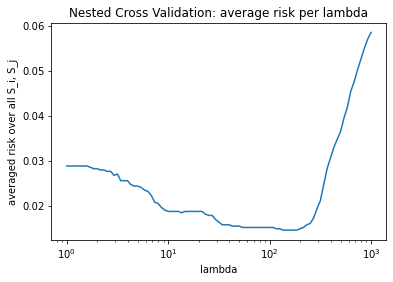

Nested cross validation yields the following model:
Best lambda: 184.78497974222907 , avg risk: 0.01515151515151515
Accuracy on training set: 0.98989898989899
L2 norm: 0.11036552777177114


In [45]:
ridgeClassificationNestedCrossValidation, bestLbdaRidgeClassification, avgRiskRidgeClassification = nestedCrossValidationRidgeClassification(X, y)
print("Nested cross validation yields the following model:")
print("Best lambda:", bestLbdaRidgeClassification, ", avg risk:", avgRiskRidgeClassification)
print("Accuracy on training set:", ridgeClassificationNestedCrossValidation.accuracy(X, y))
print("L2 norm:", L2Regularizer(ridgeClassificationNestedCrossValidation.getThetaNormalized()))

Let's look at the Precision/Recall Curve of our model:

In [24]:
def getTpFpTnFn(model, X, y_true):
    y_pred = model.predict(X)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            if y_true[i] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if y_true[i] == 1:
                fn += 1
            else:
                tn += 1
    return tp, fp, tn, fn

def precisionAndRecall(model, X, y_true):
    tp, fp, tn, fn = getTpFpTnFn(model, X, y_true)
    if tp == 0:
        return 0, 0
    return tp/(tp+fp), tp/(tp+fn)

def precisionRecallCurve(model, X, y):
    formerTheta0 = model.getThetaNormalized()[0].copy()
    precisions, recalls = [], []
    for theta0 in np.arange(-5, 5, 0.01):
        model.thetaNormalized[0] = theta0
        precision, recall = precisionAndRecall(model, X, y)
        if precision != 0 or recall != 0:
            recalls.append(recall)
            precisions.append(precision)
    model.thetaNormalized[0] = formerTheta0 # don't alter the model
    precision, recall = precisionAndRecall(model, X, y)
    plt.plot(recalls, precisions)
    plt.scatter([recall], [precision], color="red")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision/recall curve")
    plt.legend(["Precision/recall curve, with different theta_0", "this model"])
    plt.show()

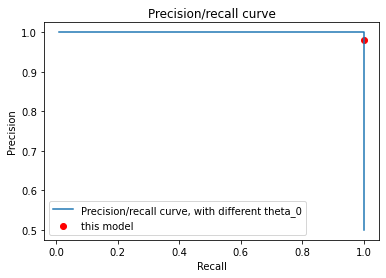

This model has a precision of 0.9801980198019802 and a recall of 1.0


In [25]:
precisionRecallCurve(ridgeClassificationNestedCrossValidation, X, y)
precision, recall = precisionAndRecall(ridgeClassificationNestedCrossValidation, X, y)
print("This model has a precision of", precision, "and a recall of", recall)

As we see, our precision is not quite 100%, yet our recall is. The latter is more important to us, since we really want to detect all defect lasers. We don't care so much if we accidentally misclassify an actually working laser as faulty. With a greater $\theta_0$, we could achieve both values to be 100%, but that deteriorates our L2 norm

## Perceptron

Just for fun: since we can construct a ridge classifier with 100% accuracy (100% precision and recall), we know our data is linearly separable. So we can construct a perceptron:

In [26]:
def perceptronLoss(y_pred, y_true):
    return max(0, -y_pred*y_true)

class Perceptron():
    def __init__(self, X, y):
        n = X.shape[0]
        X_train = X.copy()
        self.means = np.zeros(X.shape[1])
        self.stds = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            self.means[j] = X[:, j].mean()
            self.stds[j] = X[:, j].std()
            X_train[:, j] = (X_train[:, j] - self.means[j]) / self.stds[j]
        X_train = np.hstack((np.ones((n, 1)), X))
        self.thetaNormalized = np.ones(X_train.shape[1])
        while True:
            thetaChanged = False
            for i in range(n):
                y_pred = np.dot(X_train[i], self.thetaNormalized)
                if perceptronLoss(y_pred, y[i]) > 0:
                    self.thetaNormalized += y[i] * X_train[i]
                    thetaChanged = True
            if not thetaChanged:
                break
    def score(self, X):
        X_query = X.copy()
        for j in range(X_query.shape[1]):
            X_query[:, j] = (X_query[:, j] - self.means[j]) / self.stds[j]
        return X_query @ self.thetaNormalized[1:len(self.thetaNormalized)] + self.thetaNormalized[0]
    def predict(self, X):
        scores = self.score(X)
        scores[scores <= 0] = -1
        scores[scores > 0] = 1
        return scores
    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        return sum(y_pred == y_true) / len(y_true)

In [27]:
perceptron = Perceptron(X[0:150], y[0:150])
print("Accuracy of Perceptron:", perceptron.accuracy(X[150:198], y[150:198]))

Accuracy of Perceptron: 0.875


As we see, the accuracy of the Perceptron is significantly worse than that of the ridge classfication (Would we have trained the ridge classificator on the first 150 instances too, we would have achieved an accuracy on the last 48 instances of 100%). This may be due to the gradient descent, which is not as precise as an analytic solution.

# Random forest

For this, we use the Random Forest from sklearn, since it is optimized in any way possible. A random forest is able to classify around at least 95% of test instances correctly, if trained on 150 training instances:

In [56]:
from sklearn.ensemble import RandomForestClassifier
for n in [1, 5, 10, 50, 100, 200, 500, 1000]:
    skForest = RandomForestClassifier(n_estimators=n)
    skForest.fit(X[0:150], y[0:150])
    y_pred = skForest.predict(X[150:198])
    print("Accuracy of sklearn's random forest with", n, "trees:", sum(y_pred==y[150:198])/len(y[150:198]))

Accuracy of sklearn's random forest with 1 trees: 0.9583333333333334
Accuracy of sklearn's random forest with 5 trees: 0.9791666666666666
Accuracy of sklearn's random forest with 10 trees: 0.9375
Accuracy of sklearn's random forest with 50 trees: 0.9791666666666666
Accuracy of sklearn's random forest with 100 trees: 0.9791666666666666
Accuracy of sklearn's random forest with 200 trees: 0.9791666666666666
Accuracy of sklearn's random forest with 500 trees: 0.9791666666666666
Accuracy of sklearn's random forest with 1000 trees: 0.9791666666666666


Appearantly, the number of trees doesn't really influence the accuracy for large values, so we're going to leave it at the default of 100.

# Kernel Ridge Classifiation vs. Ridge Regression vs. Random Forest

Now, let's compare these three models. We train them on the same number of training instances and observe their accuracy on the rest of instances.

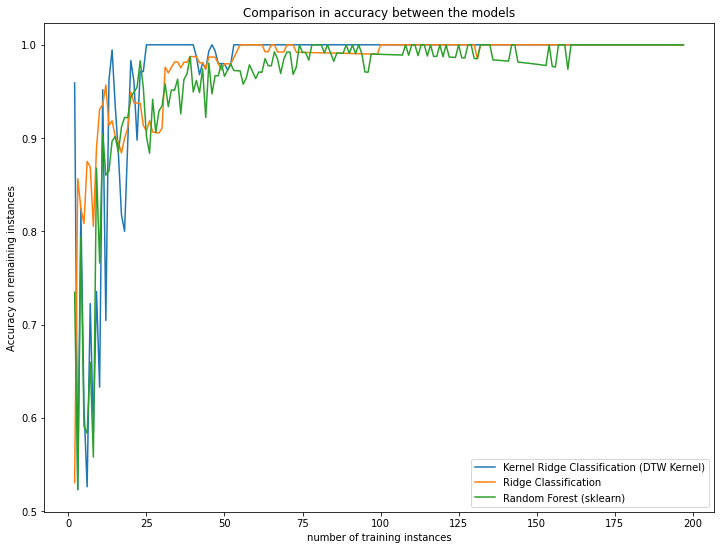

In [55]:
minTrainingInstances = 2
maxTrainingInstances = 197
accsKernelTest = np.zeros(maxTrainingInstances - minTrainingInstances + 1)
accsRidgeTest = np.zeros(maxTrainingInstances - minTrainingInstances + 1)
accsForestTest = np.zeros(maxTrainingInstances - minTrainingInstances + 1)
nrsTrainingInstances = np.arange(minTrainingInstances, maxTrainingInstances+1)

for i in nrsTrainingInstances:
    training_indices = np.arange(0, i)
    test_indices = np.arange(i, 198)
    kernel_i = DTWClassifier(X[training_indices],
                             y[training_indices],
                             D[np.ix_(training_indices, training_indices)],
                             bestLbdaDTWKernel,
                             X,
                             D[:,training_indices])
    accsKernelTest[i - minTrainingInstances] = kernel_i.accuracy(X[test_indices], y[test_indices])
    ridge_i = RidgeClassifier(X[training_indices], y[training_indices], bestLbdaRidgeClassification)
    accsRidgeTest[i - minTrainingInstances] = ridge_i.accuracy(X[test_indices], y[test_indices])
    forest_i = RandomForestClassifier()
    forest_i.fit(X[training_indices], y[training_indices])
    y_pred_forest_i = forest_i.predict(X[test_indices])
    accsForestTest[i - minTrainingInstances] = sum(y_pred_forest_i == y[test_indices]) / len(y_pred_forest_i)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(nrsTrainingInstances, accsKernelTest)
ax.plot(nrsTrainingInstances, accsRidgeTest)
ax.plot(nrsTrainingInstances, accsForestTest)
plt.xlabel("number of training instances")
plt.ylabel("Accuracy on remaining instances")
# ax.set_xscale("log")
plt.title("Comparison in accuracy between the models")
plt.legend(["Kernel Ridge Classification (DTW Kernel)", "Ridge Classification", "Random Forest (sklearn)"])
plt.show()

All three models perform very good when trained on more than 50 instances, to the point where all of them have an accuracy of 100%. The random forest performs the most instable, as there might be constellations of instances and features which just don't lead to a perfect model. The accuracy switches between 100% and a value that is decreasing as the number of training instances increases. So for larger samples, this specific random forest might not be suitable. The best performance is delivered by the the DTW kernel. This might come expected, since it is the only model that actually incorporates time in way, and the features we deal with are timepoints. Although one could argue that the indidivual instances are not really comparable in detail, so the time incorporation doesn't completely apple here. As we also see, the "normal" ridge classification does also a good job, especially when trained with more than 100 instances.

In conclusion, for further application, the DTW kernel might be the best solution; nevertheless of course depending on the exact field.